# Evaluating the Predictive Capabilities of "Predictive Testing"
## Predicting NCLEX Success for Nursing Students
Author: Alexander Stachniak

# Modules
All Python modules used are fairly common and will be installed as a default for users running Anaconda, with the possible exception of graphviz.

In [60]:
# Standard modules
import pandas as pd
import numpy as np
import pickle
import datetime

# Plotting modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.mlab as mlab
# Display plots within Jupyter Notebook
%matplotlib inline
# Set default plot size
plt.rcParams['figure.figsize'] = (14, 5)
# Seaborn used for its excellent correlation heatmap plot
import seaborn as sns
# Used for plotting trees
from sklearn import tree
import graphviz

# SciKit Learn Pre-Processing Methods
from sklearn.preprocessing import Imputer

# SciKit Learn Sampling and Selection Methods
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV

# SciKit Learn Models
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# SciKit Learn Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, log_loss, precision_recall_fscore_support

# SciPy Modules
from scipy.stats import ttest_ind, f_oneway, norm, percentileofscore

# Caution: use only when certain of results
import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [748]:
with open('NCLEX_data.pickle', 'rb') as file:
    nclex = pickle.load(file)
with open('PA_data.pickle', 'rb') as file:
    pa = pickle.load(file)

## Preparing Target Variable
Our target variable is the result of the NCLEX exam, either "Pass" or "Fail." As our first data preparation step, we will ensure that our data is consistent.

In [749]:
# Set ID as the index
nclex = nclex.set_index('Student ID')
# Sort by the index (ID)
nclex = nclex.sort_index()

In [750]:
# View data
nclex.head()

,Result
Student ID,
0,PASS
1,PASS
2,pass
4,FAIL
5,PASS


In [751]:
# As we can see, we need to do account for some variance in how the target attribute is stored
nclex['Result'].unique().tolist()

['PASS', 'pass', 'FAIL', 'fail', 'Pass', 'Fail']

In [752]:
# Convert Result to integer values
result_map = {'FAIL': 0,
              'Fail': 0,
              'fail': 0,
              'PASS': 1,
              'Pass': 1,
              'pass': 1}
nclex['Result'] = nclex['Result'].map(result_map)

In [753]:
# View the duplicates to ensure we're not going to lose any data
nclex[nclex.index.duplicated(keep=False)]

,Result
Student ID,
71,0
71,0
1411,1
1411,1


In [754]:
# We can use the tilde (inverse) and duplicated method to drop duplicates
nclex = nclex[~nclex.index.duplicated(keep='first')]

In [755]:
# View target data
nclex.head()

,Result
Student ID,
0,1
1,1
2,1
4,0
5,1


In [756]:
# Review class imbalance
nclex['Result'].value_counts()

1    877
0    104
Name: Result, dtype: int64

## Inner Join of Data
We want to be sure that we are not retaining student data in one dataframe that does not exist in the others. So, we will perform an inner join of student IDs, and retain data only for those IDs moving forward.

In [757]:
# Multi-part operation:
# 1) Merge statement to produce an inner join on two dataframes
# 2) Keep only the "Student ID" field
# 3) Drop true duplicates
# 4) Reset index from 0
student_ids = nclex.merge(pa, left_index=True, right_on='Student ID')['Student ID'].drop_duplicates().reset_index(drop=True)

In [758]:
# Keep only the student IDs that are represented across all dataframes
nclex = nclex.ix[student_ids]
pa = pa[pa['Student ID'].isin(student_ids)]

In [759]:
# Total number of observations
len(nclex)

959

## Preparing the Predictive Assessment Data
The predictive testing product contained multiple categories of assessments (e.g. Medical/Surgical, Pediatrics, etc.) as well as multiple versions within each category containing different questions. Assessment and Assessment ID identify the assessment, and Booklet ID is a unique identifier for the test-taker. Date Taken identifies the date and time that the exam was begun.

For each assessment, several numerical scores are provided:
* Score (raw score)
* National Mean
* National Percentile
* Program Mean
* Program Percentile
* Proficiency Level (meant to indicate level of mastery; is based on a proprietary algorithm).

Each assessment is further broken down by section, where each section indicates a theoretical grouping of questions intended to provide an indication of the level of mastery of specific sub-topics. Numerical scores are provided both for the overall assessment and for each individual section.

In [760]:
pa.head()

,Assessment,Assessment ID,Booklet ID,Date Taken,National Mean,National Percentile,Proficiency Level,Program Mean,Program Percentile,Score,Section,Student ID
983,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,56.44,26.0,NaN,57.02,23.0,50.00,RN Community Health Nursing 1.0,850
984,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,56.44,26.0,NaN,57.02,23.0,50.00,Community Health,850
985,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,56.63,39.0,NaN,57.29,37.0,53.57,Advocate,850
986,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,29.16,71.0,NaN,28.85,71.0,0.00,Food Safety,850
987,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,56.56,43.0,NaN,56.49,43.0,0.00,Growth and Development,850


### Cleaning the Data
There are a few things we need to do to clean up the data so that it is easier to work with.

In [761]:
# Rename section headings that are 'overall' scores using a lambda function
def overall(Assessment, Section):
    if Section == Assessment:
        return 'Overall'
    else:
        return Section
pa['Section'] = pa.apply(lambda x: overall(x['Assessment'], x['Section']), axis=1)

### Removing Duplicates
Before we can run any kind of analysis, we need to remove duplicates from our data. Some duplicates are true duplicates (all fields duplicated), so those are dropped without any loss of data. There also appears to be some malformed data, where everything is duplicated but all of the numeric scores are lost (value = 'Nan'). Again, these are dropped without any loss of data.

In [762]:
# Drop true duplicates
pa = pa.drop_duplicates()

In [763]:
# Drop NaN in National Percentile and/or National Mean (only accompanies malformed duplicates)
pa = pa.dropna(axis=0,how='any',subset=['National Percentile'])
pa = pa.dropna(axis=0,how='any',subset=['National Mean'])

### Missing Values
We will need a plan for dealing with any missing values before we can run any analysis. First, let's take a look at where our missing values reside.

In [764]:
# Which columns contain NaNs?
pa.isnull().sum()

Assessment                 0
Assessment ID              0
Booklet ID                 0
Date Taken                 0
National Mean              0
National Percentile        0
Proficiency Level      78428
Program Mean            7470
Program Percentile      7338
Score                      0
Section                    0
Student ID                 0
dtype: int64

#### Impute Missing Values for Program Mean
Missing values in Program Mean are clustered in two specific assessments. Because we have almost 7,000 NaNs, and we don't want to have to drop this data when modeling, we will impute the missing values. Program Mean should be very simple to impute, however, since it should just be a mean value of all the scores for a particular section of a particular assessment. In order to get a little more granular than just replacing NaNs with the mean of the entire column (which wouldn't account for differences in sections or assessments), we will iterate over each section to impute mean values.

In [765]:
# First, let's look at the data.
# We make a copy of the df to avoid making unwanted changes
Prog_Nans = pa.copy(deep=True)
Prog_Nans = Prog_Nans[Prog_Nans['Program Mean'].isnull()]
Prog_Nans.head()

,Assessment,Assessment ID,Booklet ID,Date Taken,National Mean,National Percentile,Proficiency Level,Program Mean,Program Percentile,Score,Section,Student ID
8359,RN Community Health Nursing 2.1,263,2632034,Aug 19 2007 4:28PM,59.38,1.0,Below Level 1,NaN,1.0,0.0,Overall,71
8360,RN Community Health Nursing 2.1,263,2632034,Aug 19 2007 4:28PM,51.59,1.0,Below Level 1,NaN,1.0,0.0,Foundations for Community-Oriented Health,71
8361,RN Community Health Nursing 2.1,263,2632034,Aug 19 2007 4:28PM,68.15,1.0,Below Level 1,NaN,1.0,0.0,Roles and Settings,71
8362,RN Community Health Nursing 2.1,263,2632034,Aug 19 2007 4:28PM,47.35,1.0,Below Level 1,NaN,1.0,0.0,Health Care Delivery,71
8363,RN Community Health Nursing 2.1,263,2632034,Aug 19 2007 4:28PM,77.38,1.0,Below Level 1,NaN,1.0,0.0,Nursing Care of Aggregates in the Community,71


In [766]:
# These NaNs are clustered in the Community Health assessments
Prog_Nans['Assessment'].unique()

array(['RN Community Health Nursing 2.1', 'RN Community Health 2010 Form A'], dtype=object)

In [767]:
# Closer look at missing values
for assessment in Prog_Nans['Assessment'].unique():
    NaNs = len(pa[(pa['Assessment'] == assessment) & (pa['Program Mean'].isnull())])
    Total = len(pa[(pa['Assessment'] == assessment)])
    print('Assessment: {}'.format(assessment))
    print('{0:5d} NaNs / {1:5d} Total = {2:6.2f}% Missing'.format(NaNs, Total, (NaNs/Total)*100))

Assessment: RN Community Health Nursing 2.1
  288 NaNs /   906 Total =  31.79% Missing
Assessment: RN Community Health 2010 Form A
 7182 NaNs /  7182 Total = 100.00% Missing


In [768]:
# Initialize the mean_imputer (axis=0 means it will impute mean of column)
mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [769]:
# Iterate through each section of each assessment (for localized means)
for assessment in Prog_Nans['Assessment'].unique():
    for section in Prog_Nans[Prog_Nans['Assessment'] == assessment]['Section'].unique():
        # Copy df and remove unnecessary features
        impute_df = Prog_Nans.copy(deep=True)
        impute_df = impute_df[(impute_df['Assessment'] == assessment) & (impute_df['Section'] == section)]
        impute_df = impute_df[['Program Mean', 'Score']]
        # Fit and transform imputer
        impute_df['Program Mean'] = mean_imputer.fit_transform(impute_df)
        # Add imputed values to df using fillna
        pa['Program Mean'].fillna(value=impute_df['Program Mean'], inplace=True)

#### Impute Missing Values for Program Percentile
Missing values for Program Percentile should be easy to compute now that we have all of the Program Means. We'll use scipy's percentileofscore function to generate our percentiles. Again, we want to calculate percentiles for each section of each assessment. We want to apply a function over each row of a Pandas dataframe, but we need to be careful to pass both the full range of scores and a single score to each call of the percentile function.

In [770]:
# Copy df where Program Percentile is NaN
Percentile_Nans = pa.copy(deep=True)
Percentile_Nans = Percentile_Nans[Percentile_Nans['Program Percentile'].isnull()]

In [771]:
# Note that in this function we need to take the score for each observation and determine the percentile against
# the overall range of scores. So the first argument in percentileofscore is not taken row by row.
def percentile(row):
    'A simple function to calculate percentiles'
    return percentileofscore(impute_df['Score'], row['Score'])

In [772]:
# Iterate through each section of each assessment (localized percentiles)
for assessment in Percentile_Nans['Assessment'].unique():
    for section in Percentile_Nans[Percentile_Nans['Assessment'] == assessment]['Section'].unique():
        # Copy df and remove unnecessary features
        impute_df = Percentile_Nans.copy(deep=True)
        impute_df = impute_df[(impute_df['Assessment'] == assessment) & (impute_df['Section'] == section)]
        impute_df = impute_df[['Program Percentile', 'Score']]
        # Apply percentile function
        impute_df['Program Percentile'] = impute_df.apply(percentile, axis=1)
        # Add imputed values
        pa['Program Percentile'].fillna(value=impute_df['Program Percentile'], inplace=True)

In [773]:
# Which columns still contain NaNs?
pa.isnull().sum()

Assessment                 0
Assessment ID              0
Booklet ID                 0
Date Taken                 0
National Mean              0
National Percentile        0
Proficiency Level      78428
Program Mean               0
Program Percentile         0
Score                      0
Section                    0
Student ID                 0
dtype: int64

In [774]:
# Percent of data missing for Proficiency Level
NaNs = pa['Proficiency Level'].isnull().sum()
Total = pa.shape[0]
print('Proficiency Level: {0:5d} NaNs / {1:6d} Total = {2:5.2f}% Missing'.format(NaNs, Total, (NaNs/Total)*100))

Proficiency Level: 78428 NaNs / 250537 Total = 31.30% Missing


#### Dropping Proficiency Level
Proficiency level is not based simply on a cutoff value of the raw score for a test, but is a proprietary algorithm. Proficiency levels change over time and are different for different assessments. Although we could attempt to develop a model to predict proficiency level based on the other variables, such a model would ensure a high amount of covariance between proficiency level and whatever other variables were used in the model. This covariance would eventually cause problems down the road. Moreover, we would much rather make use of the raw score and national mean to create a "Dist to National Mean" (more on this later). Avoiding any reliance on a proprietary algorithm will make our model more robust and resistant to future changes. For example, should the client elect to use a different predictive testing vendor, so long as that vendor reports raw scores and national means, it is likely that we could make it work with past data. For this reason, as well as the high amount of missing data, we elect to drop Proficiency Level rather than impute missing values.

## Correct Section Names
Each exam is broken down into "sections" which represent a theoretical category of knowledge/learning. There are 285 unique section names, however, there are quite a few inconsistencies. Over time, the testing vendor corrected errors and made slight changes to many sections, such as "Therapeutic Communications" to "Therapeutic Communication". Because the students' scores on these sections will represent our explanatory variables, we must first normalize all of the obvious inconsistencies. After normalizing, we are left with 212 unique section headings.

We may also wish to map these sections to higher order concepts. For example, we may be better served by combining "Spelling" and "Grammar" into "Basic English" to represent a combination of a student's skill in one particular area. 

In [775]:
# Read in section names and conceptual connections
sections_df = pd.read_csv('section_names.csv')

In [776]:
sections_df.head()

,Original,Corrected,Concept,Root
0,Abuse/Neglect,Abuse/Neglect,Abuse/Neglect,Mental Health
1,Accident Prevention,Accident/Error/Injury Prevention,Accident/Error/Injury Prevention,Safety
2,Accident/Error/Injury Prevention,Accident/Error/Injury Prevention,Accident/Error/Injury Prevention,Safety
3,Accident/Injury Prevention,Accident/Error/Injury Prevention,Accident/Error/Injury Prevention,Safety
4,Advance Directives,Advanced Directives,Advanced Directives,Leadership


In [777]:
def add_to_dict(key, value, user_dict):
    user_dict[key] = value

In [778]:
def create_concept_map(key1, key2, value, user_dict):
    # Create dictionary levels as needed
    if key1 not in user_dict.keys():
        user_dict[key1] = {}
        if key2 not in user_dict[key1].keys():
            user_dict[key1][key2] = {}
    # Add to dictionary
    user_dict[key1][key2] = value

In [779]:
# Initialize empty dictionaries for storage
original_to_corrected = {}
original_to_concept = {}
original_to_root = {}
concept_map = {}
# Iterate through to build dictionaries and new field in df
for dct,col in zip([original_to_corrected, original_to_concept, original_to_root], sections_df.columns[1:]):
    # Build dictionary
    sections_df.apply(lambda x: add_to_dict(x['Original'], x[col], dct), axis=1);
    # Add field to df
    pa[col] = pa['Section'].replace(dct)
# Build a concept map
sections_df.apply(lambda x: create_concept_map(x['Root'], x['Concept'], x['Corrected'], concept_map), axis=1);

In [780]:
pa.head()

,Assessment,Assessment ID,Booklet ID,Date Taken,National Mean,National Percentile,Proficiency Level,Program Mean,Program Percentile,Score,Section,Student ID,Corrected,Concept,Root
983,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,56.44,26.0,NaN,57.02,23.0,50.00,Overall,850,Overall,Overall,Overall
984,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,56.44,26.0,NaN,57.02,23.0,50.00,Community Health,850,Community Health Nursing,Community Health Nursing,Community Health
985,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,56.63,39.0,NaN,57.29,37.0,53.57,Advocate,850,Advocacy,Advocacy,Leadership
986,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,29.16,71.0,NaN,28.85,71.0,0.00,Food Safety,850,Food Safety,Nutrition,Community Health
987,RN Community Health Nursing 1.0,14,1487164,Jun 1 2005 6:02PM,56.56,43.0,NaN,56.49,43.0,0.00,Growth and Development,850,Growth and Development,Growth and Development,Pediatrics


In [781]:
# Review Number of Fields at Each Level
print('Root Concepts: {0}\nGeneral Concepts: {1}\nCorrected Sections: {2}'.format(len(pa['Root'].unique()), len(pa['Concept'].unique()), len(pa['Corrected'].unique())))

Root Concepts: 13
General Concepts: 161
Corrected Sections: 212


### Create New Features
Intuitively we might expect Distance to the National Mean to match very well with our overall prediction of NCLEX success. To understand why, we need to understand more about the NCLEX.

The NCLEX uses Computerized Adaptive Testing (CAT), which displays questions to candidates in a way that attempts to understand each candidate's ability while using as few questions as possible. A standard exam requires all candidates to answer the same questions, while CAT attempts to always display questions that a candidate should find challenging (based on his or her ability). 

But how can the NCLEX know how challenging each question is? The answer is that questions must be tested ahead of time across a wide sample of respondents. This is the first instance where something similar to a "National Mean" plays a role in determining pass rate.

The second instance is in the actual decision rules of whether a candidate passes or fails. The passing standard is based, at least partially, on past NCLEX results, sample test-takers, and education readiness of high-school graduates interested in nursing. All of these are related to a National Mean.

In [782]:
# Calculate distance to National Mean
pa['Dist to National Mean'] = pa.apply(lambda x: x['Score'] - x['National Mean'],axis=1)

# Reshape Data and Combine Scores
We would like to use the National Mean as our baseline score in all cases (note that the National Mean is dependent on the Assessment, and may change over time; we are interested in whatever the current mean is). 

We have a significant amount of inconsistencies that can arise in our data, especially over time:
* Each student will start out having only taken a small portion of the total number of Assessments, and will not complete all Assessments until they graduate (at which point, it is too late for remediation).
* The educational program can change (e.g., offer Assessments in a different order, or skip some entirely).
* An individual student could take courses part-time, or out of order, causing the Assessments to be taken out of order.
* An individual student could take multiple versions of an assessment (as practice or as remediation).
We are looking for a method of aggregating results that is resistant to these differences. In order for our model to be useful, we need to be able to make a prediction for any student, regardless of their place in the program and regardless of the order they have taken assessments.

The solution is to start every student at a baseline of 0.0 for each concept. Whenever a student takes an assessment in which he or she is graded on a particular concept, we will calculate the distance to the national mean for that particular assessment and concept, then average their distance scores together as their new baseline.

In [783]:
# Make a deep copy of the data
df = pa.copy(deep=True)

Groupby is an example of a Panda's function that has been optimized using row calculations. When we take the mean of "Dist to National Mean" while grouping by Student ID and Concept, we accomplish the same thing that we would if we iterated over each Student ID, then iterated over each Concept, averaged the matching values in the dataframe, then added to a new dataframe. The difference is that Groupby does all of these calculations as row calculations and doesn't have to perform costly look-ups, increasing the speed exponentially. 

In [784]:
# Groupby, Average, and Unstack
df = df['Dist to National Mean'].groupby([df['Student ID'], df['Concept']]).mean().unstack()

In [785]:
# Divide by 100 to standardize the data. Fill NaNs with 0.0
df = df.divide(100, fill_value=0.0)

In [786]:
df.head()

Concept,Abuse/Neglect,Accident/Error/Injury Prevention,Advanced Directives,Adverse Effects/Contraindications/Side Effects/Interactions,Advocacy,Aging Process,Alterations in Body Systems,Ante/Intra/Postpartum and Newborn Care,Assistive Devices,Basic English,...,Techniques of Physical Assessment,Therapeutic Communication,Therapeutic Environment,Therapeutic Milieu,Therapeutic Procedures,Total Parenteral Nutrition,Treatment Modalities,Unexpected Response to Therapies,Urinary,Use of Restraints/Safety Devices
Student ID,,,,,,,,,,,,,,,,,,,,,
0,0.041700,-0.025029,0.0000,0.195767,-0.31430,0.175633,-0.025520,0.02090,-0.05105,0.0,...,0.3249,-0.085050,0.317,0.0,0.326775,0.0498,0.0,-0.382300,0.0,0.3537
1,-0.285133,0.050643,0.6047,0.009320,0.58375,-0.212300,0.134550,0.17935,-0.03150,0.0,...,0.2809,0.146933,0.000,0.0,0.407325,0.0559,0.0,-0.062467,0.0,0.3123
4,0.048200,0.000013,0.6047,0.094167,0.08375,-0.545633,-0.024943,-0.16440,-0.03150,0.0,...,-0.7191,0.202500,0.000,0.0,-0.183460,0.0559,0.0,-0.307600,0.0,0.3123
5,0.131533,0.156262,0.6047,0.118717,0.08375,0.121033,-0.070600,0.08560,-0.03150,0.0,...,0.2809,-0.297500,0.000,0.0,-0.086780,0.3059,0.0,0.067400,0.0,0.3123
6,0.258350,0.023329,0.0000,0.016050,0.00000,0.488933,0.193700,-0.15310,-0.09375,0.0,...,0.0000,0.219800,0.000,0.0,0.065267,0.0000,0.0,0.247700,0.0,0.2902


## Reviewing for Correlations and Covariance
The various concepts can be shown to have very low correlation to one another. In the plot below, we notice some significant banding, which we can attribute to the variables being listed alphabetically. Similar concepts tend to have similar names, but even still, correlations are very low.

This is also demonstrated in the Principal Component Analysis (PCA) example, in which we would need over 50 principal components to account for 80% of the variance. These results suggest that we do not need to be concerned about covariance, but also that dimensionality reduction will not be a viable option.

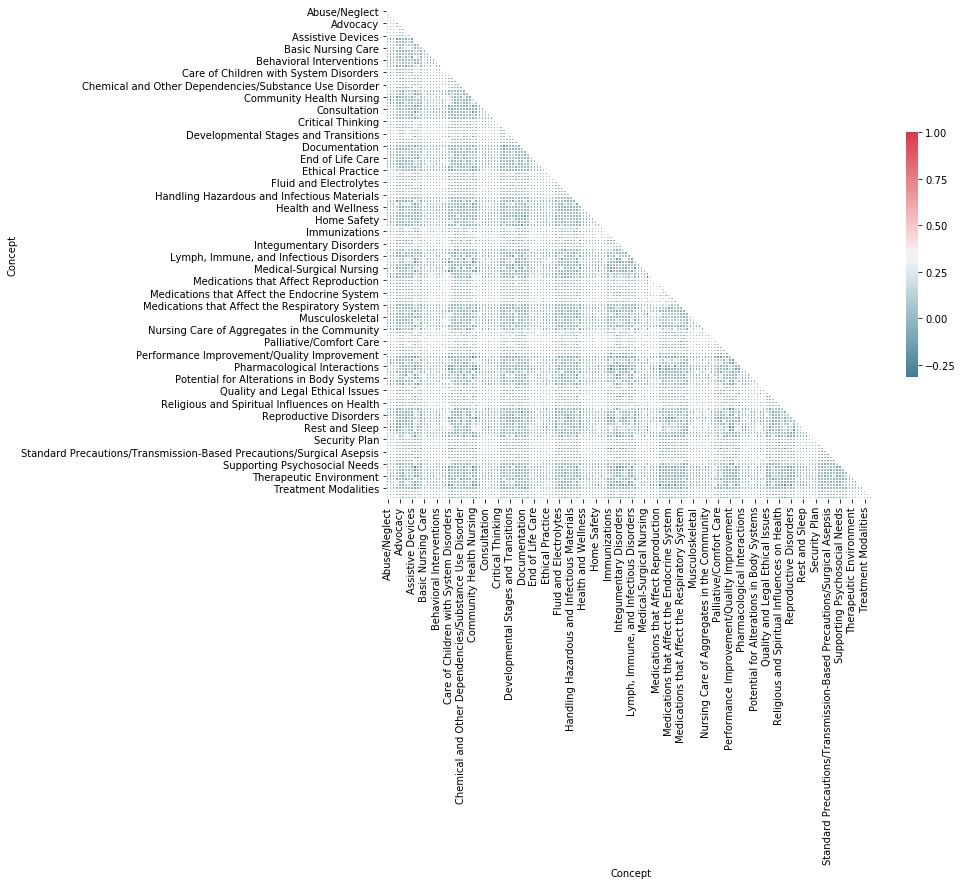

In [787]:
# Calculate correlation matrix
corr = df.corr()
# Create a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up plot
f, ax = plt.subplots(figsize=(11,9))
# Generate a colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [788]:
# Take a look at the actual correlation values
corr

Concept,Abuse/Neglect,Accident/Error/Injury Prevention,Advanced Directives,Adverse Effects/Contraindications/Side Effects/Interactions,Advocacy,Aging Process,Alterations in Body Systems,Ante/Intra/Postpartum and Newborn Care,Assistive Devices,Basic English,...,Techniques of Physical Assessment,Therapeutic Communication,Therapeutic Environment,Therapeutic Milieu,Therapeutic Procedures,Total Parenteral Nutrition,Treatment Modalities,Unexpected Response to Therapies,Urinary,Use of Restraints/Safety Devices
Concept,,,,,,,,,,,,,,,,,,,,,
Abuse/Neglect,1.000000,-0.017857,0.017873,0.075731,0.016614,0.033584,0.101072,0.118378,0.094609,0.006207,...,0.047227,0.046511,0.090619,-0.013397,0.028307,0.000402,-0.007065,0.058507,-0.003698,0.000746
Accident/Error/Injury Prevention,-0.017857,1.000000,0.116259,0.169444,0.034411,0.147999,-0.001164,0.136267,0.022216,-0.167305,...,0.001156,-0.044450,-0.112776,-0.016326,0.012378,0.167302,0.005652,0.080709,-0.004518,0.127432
Advanced Directives,0.017873,0.116259,1.000000,0.060477,0.053675,-0.021204,-0.012392,0.049125,-0.009377,-0.045391,...,-0.008790,0.018203,-0.058048,-0.007489,0.059277,0.049858,-0.002753,0.049729,-0.009355,-0.010311
Adverse Effects/Contraindications/Side Effects/Interactions,0.075731,0.169444,0.060477,1.000000,-0.016532,0.009695,0.312561,0.233055,0.146882,-0.153063,...,0.120829,0.076673,0.102482,-0.059504,0.308163,0.240603,0.000248,0.089313,-0.030979,0.133832
Advocacy,0.016614,0.034411,0.053675,-0.016532,1.000000,0.030603,0.015395,0.056993,-0.006701,-0.098157,...,0.013604,0.031884,0.012583,-0.001456,0.054195,-0.003038,0.014180,0.058887,-0.008386,0.083690
Aging Process,0.033584,0.147999,-0.021204,0.009695,0.030603,1.000000,0.037128,0.091299,0.031850,0.006782,...,-0.052534,-0.081247,-0.052926,-0.006093,-0.077109,-0.021931,-0.000350,0.000923,-0.003905,-0.058697
Alterations in Body Systems,0.101072,-0.001164,-0.012392,0.312561,0.015395,0.037128,1.000000,0.259984,0.157095,-0.063362,...,0.113202,0.181773,0.161322,-0.063108,0.296245,0.102611,-0.003254,0.089532,-0.040231,0.071182
Ante/Intra/Postpartum and Newborn Care,0.118378,0.136267,0.049125,0.233055,0.056993,0.091299,0.259984,1.000000,0.101068,0.079106,...,0.035478,0.092174,0.041889,0.043342,0.205689,0.178290,0.030657,0.096013,0.042975,0.051863
Assistive Devices,0.094609,0.022216,-0.009377,0.146882,-0.006701,0.031850,0.157095,0.101068,1.000000,-0.108065,...,0.094207,0.107801,0.150479,-0.030496,0.114497,0.076377,-0.012876,0.047231,-0.019824,0.091169


### PCA Example
The following example prints the explained variance ratio for each principal component, as well as plotting the cumulative explained variance ratio. As we can see, PCA is not a good fit for this data.

Explained Variance
PC1:  6.85%
PC2:  5.25%
PC3:  3.58%
PC4:  2.67%
PC5:  2.65%
PC6:  2.45%
PC7:  2.35%
PC8:  2.16%
PC9:  2.05%
PC10:  1.93%
PC11:  1.88%
PC12:  1.84%
PC13:  1.79%
PC14:  1.71%
PC15:  1.68%
PC16:  1.62%
PC17:  1.56%
PC18:  1.52%
PC19:  1.49%
PC20:  1.43%
PC21:  1.40%
PC22:  1.37%
PC23:  1.33%
PC24:  1.31%
PC25:  1.29%
PC26:  1.25%
PC27:  1.23%
PC28:  1.20%
PC29:  1.17%
PC30:  1.14%
PC31:  1.10%
PC32:  1.08%
PC33:  1.06%
PC34:  1.05%
PC35:  1.02%
PC36:  0.99%
PC37:  0.97%
PC38:  0.95%
PC39:  0.94%
PC40:  0.91%
PC41:  0.89%
PC42:  0.88%
PC43:  0.86%
PC44:  0.85%
PC45:  0.83%
PC46:  0.81%
PC47:  0.79%
PC48:  0.79%
PC49:  0.76%
PC50:  0.75%
PC51:  0.72%
PC52:  0.71%
PC53:  0.69%
PC54:  0.66%
PC55:  0.64%
PC56:  0.62%
PC57:  0.60%
PC58:  0.58%
PC59:  0.56%
PC60:  0.56%
PC61:  0.53%
PC62:  0.51%
PC63:  0.50%
PC64:  0.48%
PC65:  0.48%
PC66:  0.45%
PC67:  0.43%
PC68:  0.42%
PC69:  0.40%
PC70:  0.39%
PC71:  0.38%
PC72:  0.37%
PC73:  0.36%
PC74:  0.34%
PC75:  0.34%
PC76:  0.33%
PC

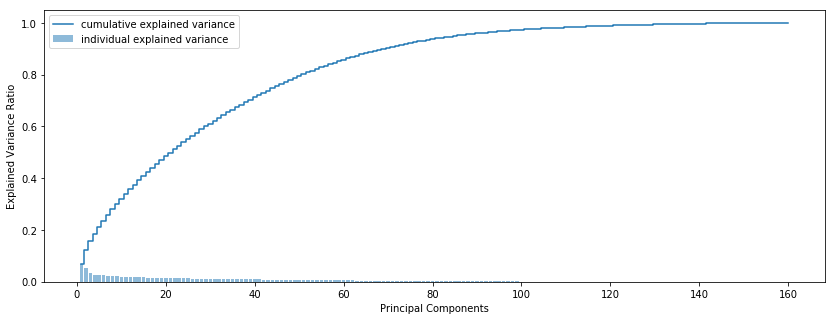

In [789]:
# Principal Component Analysis
pca = PCA(n_components=None)
pa_pca = pca.fit_transform(df)
print('Explained Variance')
for pc in range(len(pca.explained_variance_ratio_)):
    print('PC{0}: {1:5.2f}%'.format(pc+1, pca.explained_variance_ratio_[pc]*100))
# Cumulative variance
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
# Plot it
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,len(pca.explained_variance_ratio_)+1), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

# Pickle Data for Future Use
Though not a necessary step, pickling the data at this point will allow us to avoid re-running the cleaning process above each time we revisit our data for modeling. This step allows us to "freeze" our data at this point in time.

In [790]:
# Pickle the data for future use
with open('vars.pickle', 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)
with open('target.pickle', 'wb') as f:
    pickle.dump(nclex, f, pickle.HIGHEST_PROTOCOL)
with open('concept_map.pickle', 'wb') as f:
    pickle.dump(concept_map, f, pickle.HIGHEST_PROTOCOL)

# Load Data

In [2]:
with open('vars.pickle', 'rb') as file:
    df = pickle.load(file)
with open('target.pickle', 'rb') as file:
    target = pickle.load(file)
with open('concept_map.pickle', 'rb') as file:
    concept_map = pickle.load(file)

# Data Distribution

In [3]:
def plot_histograms (df, **kwargs):
    '''Function to plot multiple distributions of variables from a Pandas dataframe.
    
    @ Parameters:
    ---------------
    df: a Pandas dataframe or series
    
    @ kwargs (optional):
    ---------------
    num_cols: the number of columns to plot in subplot (integer)
    ax_width: the width of each column (integer)
    bin_size: the number of bins to use in the histograms (integer)
    color: a color value for all plots
    xlim: a minimum and maximum range to apply to all histograms (list with two values)
    title_size: a valid matplotlib text size (defaul: 'x-small')
    '''
    # Pull kwargs, if offered
    num_cols = kwargs.pop('num_cols', 5)
    ax_width = kwargs.pop('ax_width', 3)
    bin_size = kwargs.pop('bin_size', 20)
    color = kwargs.pop('color', 'blue')
    xlim = kwargs.pop('xlim', [-1.0, 1.0])
    title_size = kwargs.pop('title_size', 'x-small')
    
    # Determine basic sizes
    columns = df.columns
    num_items = len(columns)
    num_rows = int(np.ceil(num_items / num_cols))
    
    # Set plot size
    plot_width = num_cols * ax_width
    plot_height = num_rows * ax_width
    plt.rcParams['figure.figsize'] = (plot_width, plot_height)
    
    # Build array of subplots
    f, axarr = plt.subplots(num_rows, num_cols)
    
    item_locator = 0
    # Iterate through rows and columns
    for r in range(num_rows):
        for c in range(num_cols):
            if item_locator < num_items:
                # Gather data
                temp_data = df[columns[item_locator]]
                # Gather mean and standard deviation
                mu = np.mean(temp_data)
                sigma = np.std(temp_data)
                # Prepare Title
                title = '{0}\nMu: {1:.2f} | Sigma: {2:.2f}'.format(columns[item_locator], mu, sigma)
                # Plot histogram
                N, bins, patches = axarr[r, c].hist(temp_data, bins=bin_size, normed=1, color=color, edgecolor='black', alpha=0.6)
                # Add 'best fit' line
                y = mlab.normpdf(bins, mu, sigma)
                l = axarr[r, c].plot(bins, y, 'r--', linewidth=1)
                # Plot options
                axarr[r, c].set_title(title, size=title_size)
                axarr[r, c].set_xlim(xlim)
                # Increment item_locator
            item_locator += 1
    plt.tight_layout()
    plt.show()

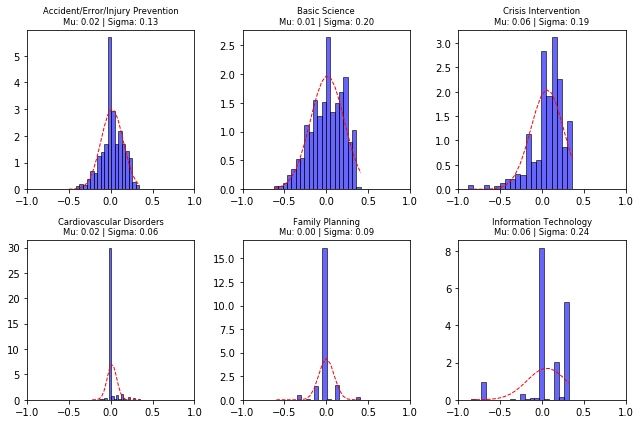

In [4]:
# Plot a few sample distributions to get a feel for the data
sample_cases = ['Accident/Error/Injury Prevention', 'Basic Science', 'Crisis Intervention', 'Cardiovascular Disorders', 'Family Planning', 'Information Technology']
plot_histograms(df[sample_cases], num_cols=3, title_size='small')

# Examining Feature Importance Using Random Forest

In [29]:
# Convert columns to numpy array for indexing purposes
feat_list = np.array(x_train.columns)
# Fit forest
forest = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
forest.fit(x_train, y_train)
# Gather feature importances
importances = forest.feature_importances_

In [30]:
# Gather ranked indices of feature importances
indices = np.argsort(importances)[::-1]
for f in range(len(feat_list)):
    print('{0:3d} ({1:.4f}) {2}'.format(f + 1, importances[indices[f]], feat_list[indices[f]]))

  1 (0.0561) Overall
  2 (0.0286) Management of Care
  3 (0.0247) Psychosocial Integrity
  4 (0.0197) Basic Nursing Care
  5 (0.0187) Expected Actions/Outcomes
  6 (0.0183) Alterations in Body Systems
  7 (0.0183) Ante/Intra/Postpartum and Newborn Care
  8 (0.0171) Behavioral Interventions
  9 (0.0168) Diagnostics
 10 (0.0167) Potential for Alterations in Body Systems
 11 (0.0159) Parenteral/Intravenous Therapies
 12 (0.0158) Critical Thinking
 13 (0.0157) Reduction of Risk Potential
 14 (0.0149) Physiological Adaptation
 15 (0.0144) Therapeutic Procedures
 16 (0.0137) Safety and Infection Control
 17 (0.0137) Nutrition
 18 (0.0132) Delegation and Prioritization
 19 (0.0126) Non-Pharmacological Comfort Interventions
 20 (0.0125) Elimination
 21 (0.0122) System Specific Assessments
 22 (0.0117) Continuity of Care
 23 (0.0115) Confidentiality/Information Security
 24 (0.0109) Leadership and Management Principles
 25 (0.0108) Health Promotion/Disease Prevention
 26 (0.0105) Basic Science


# Helper Functions and Classes

To determine the best parameters to use in our models, we will follow the same pattern each time, identifying a list of hyperparameters we want to test and then calling GridSearchCV to tune those hyperparameters. The function below is a simple wrapper for this procedure so that we can avoid repeating ourselves as much as possible.

In [4]:
def tune_parameters (x, y, clf, params, **kwargs):
    '''A simple wrapper for GridSearchCV to speed up repetitive process.
    
    @ Parameters:
    ---------------
    x: array of explanatory variables
    y: array of target variable
    clf: an initialized Sci-Kit Learn classifier
    params: dictionary of parameters over which to search
    
    @ **kwargs (optional):
    ----------------------
    folds: number of cross-validation folds to use (see GridSearchCV docs for other options)
    scoring_metric: a scorer to evaluate hyperparameters (if None, will use model default)
    
    @ Returns:
    ----------------------
    best_params_: a dictionary of the best parameters
    cv_results_: a dictionary of all results
    '''
    
    # Gather data from kwargs, if supplied; otherwise, use defaults
    folds = kwargs.pop('folds', 10)
    scoring_metric = kwargs.pop('scoring_metric', None)
    
    # Initialize grid search instance
    gs = GridSearchCV(clf, param_grid=params, cv=folds, scoring=scoring_metric, n_jobs=-1, refit=False)
    # Fit grid search model
    gs.fit(x, y)
    
    return gs.best_params_, gs.cv_results_

The class below is a bootstrap method designed as an iterator that will work with GridSearchCV. GridSearchCV is designed to be able to take custom cross validation methods, but it only provides k-fold methods out of the box. Building our own iterator allows us to use bootstrapping during hyperparameter tuning. This is not strictly necessary, and will slow down the grid search somewhat, but would expect it to produce more accurate results, especially as we increase m, the number of times to sample with replacement.

In [5]:
class Bootstrap_Indices:
    '''A cross-validation iterator that will work with GridSearchCV.
    The iterator uses Sci-Kit Learn's resample method to sample with replacement and
    uses Numpy's in1d method to determine which indices will be in the test set. Also
    relies on Numpy's arange method.
    
    @ Parameters:
    ---------------
    n: number of observations
    m: number of times to sample with replacement
    
    @ Returns:
    ---------------
    an iterable of idx_train, idx_test indices
    '''
    def __init__(self, n, m):
        self.n = n
        self.m = m
        self.i = 0
    
    def __len__(self): 
        return self.m
        
    def __iter__(self):
        idx = np.arange(self.n)
        while self.i < self.m:
            self.i += 1
            idx_train = resample(idx)
            mask = np.in1d(idx, idx_train, invert=True)
            idx_test = idx[mask]
            yield idx_train, idx_test

After we tune our hyperparameters, we need to fit our model using bootstrapping and a scoring function of choice to then compare our various models and test for significance

In [6]:
def bootstrap_model (x, y, model, bootstrap_iterator):
    '''
    Function fits a given model using bootstrapping method and returns an array of scores
    using the given scoring function. User must also pass the number of epochs, i.e., the 
    number of bootstrapped samples to take and fit the model on.
    
    The Sci-Kit Learn function, resample, provides a consistent way to take a random sample 
    of our data. The defaults are to use replacement, return same shape as input, and use
    the random state instance of numpy.random
    
    @Parameters:
    --------------------
    x: explanatory variables array
    y: target array
    model: an instantiated Sci-Kit Learn model (i.e., parameters already set)
    bootstrap_iterator: an iterator that implements bootstrap indexing
    scoring_function: a valid Sci-Kit Learn scorer. User could pass their own scoring function,
        but it should be built using .make_scorer and should include the following parameters:
            y_true (array of true target results)
            y_pred (array of predicted results)
            OR 
            y_score (array of probabilities of true class)
        If scorer does not include these parameters in the first two positions, error will be raised.
    pred_method: an indication of the input needed by scoring_function (either 'labels' or 'probabilities')
    
    @Returns:
    --------------------
    score_array: an array of sequential scoring values (length = epochs)
    '''
    # Initialize scoring arrays
    accuracy_array = np.zeros(len(bootstrap_iterator))
    f1_array = np.zeros(len(bootstrap_iterator))
    log_loss_array = np.zeros(len(bootstrap_iterator))
    precision_array_1 = np.zeros(len(bootstrap_iterator))
    recall_array_1 = np.zeros(len(bootstrap_iterator))
    fscore_array_1 = np.zeros(len(bootstrap_iterator))
    support_array_1 = np.zeros(len(bootstrap_iterator))
    precision_array_0 = np.zeros(len(bootstrap_iterator))
    recall_array_0 = np.zeros(len(bootstrap_iterator))
    fscore_array_0 = np.zeros(len(bootstrap_iterator))
    support_array_0 = np.zeros(len(bootstrap_iterator))
    # Iterate through bootstrap iterator
    counter = 0
    for idx in iter(bootstrap_iterator):
        # Resample
        x_train = x.iloc[idx[0]]
        y_train = y.iloc[idx[0]]
        x_test = x.iloc[idx[1]]
        y_test = y.iloc[idx[1]]
        # Fit model
        model.fit(x_train, y_train)
        # Make predictions
        pred_array = model.predict(x_test)
        prob_array = model.predict_proba(x_test)
        # Score model
        accuracy_array[counter] = accuracy_score(y_test, pred_array)
        f1_array[counter] = f1_score(y_test, pred_array, average='weighted')
        log_loss_array[counter] = log_loss(y_test, prob_array)
        precision_array_1[counter], recall_array_1[counter], fscore_array_1[counter], support_array_1[counter] = precision_recall_fscore_support(y_test, pred_array, pos_label=1, average='binary')
        precision_array_0[counter], recall_array_0[counter], fscore_array_0[counter], support_array_0[counter] = precision_recall_fscore_support(y_test, pred_array, pos_label=0, average='binary')
        counter += 1
    
    return accuracy_array, f1_array, log_loss_array, precision_array_1, recall_array_1, fscore_array_1, support_array_1, precision_array_0, recall_array_0, fscore_array_0, support_array_0


In [7]:
def comparison (*args, **kwargs):
    '''This function prints a comparison of scores.
    
    @ Parameters:
    --------------
    *args: Any number of arrays for which you want to compare confidence intervals
    **kwargs:
        C: Confidence Interval (default = 0.95)
        labels: ordered list of labels to apply to ordered args
        scorer: name of the scoring function being compared.'''
    C = kwargs.pop('C', 0.95)
    labels = kwargs.pop('labels', ['Model {}'.format(x) for x in range(len(args))])
    scorer = kwargs.pop('scorer', None)
    max_l = len(max(labels, key=len))
    
    print('Comparison of {} Scores'.format(scorer))
    for arg, label in zip(args, labels):
        # Calculate confidence interval
        conf = norm.interval(C, loc=arg.mean(), scale=arg.std())        
        print('  {0:{1}}  Mean: {2:.2f}  Std: {3:.2f}  95%Conf: ({4:.2f}, {5:.2f})'.format(label, max_l, arg.mean(), arg.std(), conf[0], conf[1]))

In [33]:
def plot_distributions(*args, **kwargs):
    '''This function plots the distribution and confidence interval of all arrays passed to it.
    
    @ Parameters:
    --------------
    *args: Any number of arrays for which you want to visualize the distribution
    **kwargs:
        C: Confidence Interval (default = 0.95)
        num_bins: number of bins to use in histogram (default=20)
        labels: ordered list of labels to apply to ordered args
        colors: ordered list of colors to apply to ordered args
        x_lim: list representing the left and right x limits
        plot_width: an integer value representing width in inches
        plot_height: an integer value representing height in inches
        limit_outliers: if True, histograms will ignore any outliers (1.5 * IQR). Default=False.
        alpha: alpha value for plot opacity.
        scorer: name of the scoring function being compared.
        conf_lines: if 'True' will plot vertical lines to show confidence intervals
    '''

    # Gather data from kwargs, if supplied; otherwise, use defaults
    C = kwargs.pop('C', 0.95)
    num_bins = kwargs.pop('num_bins', 20)
    labels = kwargs.pop('labels', ['Model {}'.format(x) for x in range(len(args))])
    colors = kwargs.pop('colors', cm.rainbow(np.linspace(0,1,len(args))))
    x_lim = kwargs.pop('x_lim', [None, None])
    plot_width = kwargs.pop('plot_width', 14)
    plot_height = kwargs.pop('plot_height', 5)
    limit_outliers = kwargs.pop('limit_outliers', False)
    alpha = kwargs.pop('alpha', 0.6)
    scorer = kwargs.pop('scorer', None)
    conf_lines = kwargs.pop('conf_lines', False)
    
    # Set plot dimensions
    plt.rcParams['figure.figsize'] = (plot_width, plot_height)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    # Plot boxplots
    ax1.boxplot(args, vert=False, sym='rs', labels=labels)
    # Remove y-axis and set overall title (looks better than a sup title)
    #ax1.axes.get_yaxis().set_visible(False)
    if scorer:
        ax1.set_title('Distribution of {} Scores'.format(scorer))
    else:
        ax1.set_title('Distribution of Scores')
    
    # Plot histograms
    for arg, color, label in zip(args, colors, labels):
        # Determine whisker_range for histograms
        if limit_outliers == True:
            p_25 = np.percentile(arg, 25)
            p_75 = np.percentile(arg, 75)
            iqr = p_75 - p_25
            whisker_range = (p_25 - (iqr * 1.5), p_75 + (iqr * 1.5))
        else:
            whisker_range = None
        # Calculate confidence interval
        conf = norm.interval(C, loc=arg.mean(), scale=arg.std())
        # Prepare label
        l = '({0: .2f}, {1:.2f}) - {2}'.format(conf[0], conf[1], label)
        # Plot histogram
        N, bins, patches = ax2.hist(arg, bins=num_bins, range=whisker_range, color=color, edgecolor='black', alpha=alpha, label=l)
        # Plot confidence intervals
        if conf_lines == True:
            for val in conf:
                ax2.axvline(x=val, color=color, linestyle='--', alpha=alpha)

    # Set plot attributes
    plt.legend(loc='1')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.xlim(x_lim)
    plt.show()

In [9]:
def plot_decision_boundaries (X, Y, x_lab, y_lab, *args, **kwargs):
    '''Plots the decision boundaries of any number of classifiers.
    The following code is originally based on the visualization technique
    presented by Sci-Kit Learn, at 
    http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html.
    Significant modifications have been made.
    
    @ Parameters:
    ---------------
    X: explanatory variables
    Y: target feature
    x_lab: the explanatory variable to plot on the x-axis
    y_lab: the explanatory variable to plot on the y-axis
    *args: list of initialized classifiers
    
    @ **kwargs (optional):
    ---------------
    offset: +/- amount to extend mesh grid
    labels: list of classifier names
    num_cols: number of columns in plot
    ax_width: width of each column
    ax_height: height of each column
    '''
    # Pull kwargs, if offered
    offset = kwargs.pop('offset', 0.05)
    labels = kwargs.pop('labels', ['Model {}'.format(x) for x in range(len(args))])
    num_cols = kwargs.pop('num_cols', 2)
    ax_width = kwargs.pop('ax_width', 7)
    ax_height = kwargs.pop('ax_height', 5)
    
    # Determine basic sizes
    num_items = len(args)
    num_rows = int(np.ceil(num_items / num_cols))
    
    # Set plot size
    plot_width = num_cols * ax_width
    plot_height = num_rows * ax_height
    plt.rcParams['figure.figsize'] = (plot_width, plot_height)
    
    # Ensure Target Classification is an array
    cls = Y.as_matrix()
    # Gather data
    cols = [x_lab, y_lab]
    x = X[x_lab]
    y = X[y_lab]
    
    # Set up mesh grid for contour predictions
    x_min, x_max = x.min() - offset, x.max() + offset
    y_min, y_max = y.min() - offset, y.max() + offset
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Prepare subplots in grid
    f, axarr = plt.subplots(num_rows, num_cols, sharex='col', sharey='row')
    
    item_locator = 0
    # Iterate through rows and columns
    for r in range(num_rows):
        for c in range(num_cols):
            # Fit algorithm
            args[item_locator].fit(X[cols], Y)
            # Make predictions across mesh grid space
            z = args[item_locator].predict(np.c_[xx.ravel(), yy.ravel()])
            z = z.reshape(xx.shape)
            # Plot contour and scatter
            axarr[r, c].contourf(xx, yy, z, alpha=0.4)
            axarr[r, c].scatter(x, y, c=cls)
            axarr[r, c].set_title(labels[item_locator])
            item_locator += 1

    plt.show()

In [102]:
def compare_scores (*args, alternate='less', **kwargs):
    '''Function performs a series of t-tests, comparing the first element in *args to all 
    other elements. To avoid increasing the likelihood of making a Type I error, we use the
    Bonferroni method, which divides the alpha value by the number of hypotheses tested.
    
    The T-test function provided in SciPy always produces a two-side test, but the user
    can choose a one-sided test by supplying the necessary parameter.
    
    We would reject the null hypothesis when:
        * H0: a <= b, Ha: a > b : reject H0 when p/2 < alpha and t > 0
        * H0: a >= b, Ha: a < b : reject H0 when p/2 < alpha and t < 0
        * H0: a = b, Ha: a != b : reject H0 when p < alpha
        
    @ Parameters:
    ---------------
    *args: list of score arrays, where first in list is compared to all others
    alternate: value of "less", "more", or "unequal" - will determine test that is run.
        User should assume "less" means that they are testing if the scores of the first
        argument are less than the scores of all other arguments.
    
    @ **kwargs (optional):
    ---------------
    alpha: alpha value for testing (function will automatically update if required for
        one-sided test and to take into account Bonferroni method)
    labels: a list of names of the score arrays
    '''
    # Gather keyword arguments, if any
    alpha = kwargs.pop('alpha', 0.05)
    labels = kwargs.pop('labels', ['Model {}'.format(x) for x in range(len(args))])
    
    # Determine appropriate signs for hypotheses
    if alternate == 'less':
        hyp_sign_1 = '>='
        hyp_sign_2 = '<'
        q = 2
    elif alternate == 'more':
        hyp_sign_1 = '<='
        hyp_sign_2 = '>'
        q = 2
    elif alternate == 'unequal':
        hyp_sign_1 = '='
        hyp_sign_2 = '!='
        q = 1
    
    # Determine the Bonferroni correction based on number of hypotheses to test
    m = len(args) - 1
    bonferroni = alpha / m
    
    for arg, label in zip(args[1:], labels[1:]):
        # Calculate t and p
        t_statistic, p_value = ttest_ind(args[0], arg)
        hyp_state = 'Ho: {0} {1} {2}\nHa: {0} {3} {2}\nReject Ho when p/2 < {4} and t {3} 0'.format(labels[0], hyp_sign_1, label, hyp_sign_2, bonferroni)
        hyp_test = '\tT-statistic: {0:.2f}, P-value: {1}'.format(t_statistic, p_value)
        # Determine whether to reject null hypothesis
        if p_value / q < bonferroni:
            if alternate == 'less' and t_statistic < 0:
                res = 'Reject'
            elif alternate == 'more' and t_statistic > 0:
                res = 'Reject'
            elif alternate == 'unequal':
                res = 'Reject'
            else:
                res = 'Fail to reject'
        else:
            res = 'Fail to reject'
        hyp_result = '\t{0} the null hypothesis.'.format(res)
        print('\n'.join([hyp_state, hyp_test, hyp_result]) + '\n')

# Reserve 20% of Data for a Holdout Validation Set
Before we begin hyperparameter tuning, we reserve 20% of our data as a holdout validation set. Because we have a class imbalance, we stratify the split.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df, target['Result'], test_size=0.2, random_state=25, stratify=target['Result'])

### Naming Scheme

In [128]:
# Extended names for each of our models
model_names = {'adt': 'AdaBoost (Tree)',
               'rfc': 'Random Forest', 
               'tree': 'Decision Tree',
               'knn': 'K-Nearest Neighbors',
               'gnb': 'Naive Bayes', 
               'log': 'Logistic Regression', 
               'etc': 'Complete Random Trees', 
               'se1': 'Stacked Ens (4 Models)',
               'se2': 'Stacked Ens (No GNB)',
               'se3': 'Stacked Ens (No Log)'}

In [68]:
# Standard color scheme
model_colors = {'adt': 'C0',
               'rfc': 'C1', 
               'tree': 'C2',
               'knn': 'C3',
               'gnb': 'C4', 
               'log': 'C5', 
               'etc': 'C6', 
               'se1': 'C7',
               'se2': 'C8',
               'se3': 'C9'}

# Standard Classifiers
### Define Parameters and Initialize Models

In [14]:
# Decision Tree Classifier
tree_params = {'criterion': ['gini', 'entropy'],
               'max_depth': [4, 5, 6, 7, 8],
               'min_samples_leaf': [3, 5, 7]}
tree_init = DecisionTreeClassifier()

In [15]:
# Gaussian Naive Bayes Classifier
gnb_params = {}
gnb_init = GaussianNB()

In [16]:
# K-Nearest Neighbors Classifier
knn_params = {'n_neighbors': [3, 5, 7, 9, 11],
              'p': [1,2,3],
              'n_jobs': [-1]}
knn_init = KNeighborsClassifier()

In [17]:
# Logistic Regression Classifier
log_params = {'C':[1, 10, 100, 1000],
              'tol':[1e-1,1e-2,1e-3,1e-4],
              'penalty':['l1', 'l2'],
              'class_weight': ['balanced'],
              'n_jobs': [-1]}
log_init = LogisticRegression()

# Tune Hyperparameters
For the majority of our classifiers, we will perform hyperparameter tuning using GridSearchCV, then using the best set of parameters we will build our model using bootstrapping in preparation for comparing each model.

In [22]:
# Combine various parameters for each model into lists
model_names = ['tree', 'gnb', 'knn', 'log']
model_params = [tree_params, gnb_params, knn_params, log_params]
model_inits = [tree_init, gnb_init, knn_init, log_init]

In [23]:
# Set the scoring metric to use
# Note that we use "negative log loss" because we need a metric that we can maximize
scoring_param = 'neg_log_loss'

In [24]:
# Set variables for bootstrapping iterators
bootstrap_n = x_train.shape[0]
bootstrap_m_1 = 20
bootstrap_m_2 = 200

In [25]:
# Initialize dictionary for storage
models = {}
# Iterate through models
for clf, params, init in zip(model_names, model_params, model_inits):
    # Save data and parameters
    models[clf] = {}
    models[clf][clf + '_params'] = params
    models[clf][clf + '_init'] = init
    # Initialize first bootstrap iterator
    bootstrap_1 = Bootstrap_Indices(bootstrap_n, bootstrap_m_1)
    # Tune hyperparameters
    models[clf][clf + '_best_params'], models[clf][clf + '_cv_results'] = tune_parameters(x_train, y_train, init, params, folds=bootstrap_1, scoring_metric=scoring_param)
    # Update each of the model parameters with best values
    models[clf][clf + '_model'] = models[clf][clf + '_init']
    for key, value in models[clf][clf + '_best_params'].items():
        models[clf][clf + '_model'].__setattr__(key, value)
    # Initialize second bootstrap iterator
    bootstrap_2 = Bootstrap_Indices(bootstrap_n, bootstrap_m_2)
    # Gather an array of scores for significance testing using bootstrapping
    models[clf]['accuracy_scores'], models[clf]['f1_scores'], models[clf]['log_loss_scores'], models[clf]['precision_1'], models[clf]['recall_1'], models[clf]['fscore_1'], models[clf]['support_1'], models[clf]['precision_0'], models[clf]['recall_0'], models[clf]['fscore_0'], models[clf]['support_0'] = bootstrap_model(x_train, y_train, models[clf][clf + '_model'], bootstrap_2)
    

# Stacked Ensemble Classifiers
### Define Parameters and Initialize Models

In [26]:
# Using all four basic classifiers
se1_params = [('gnb', models['gnb']['gnb_model']),
              ('tree', models['tree']['tree_model']),
              ('knn', models['knn']['knn_model']),
              ('log', models['log']['log_model'])]

# Ignoring Naive Bayes
se2_params = [('tree', models['tree']['tree_model']),
              ('knn', models['knn']['knn_model']),
              ('log', models['log']['log_model'])]

# Ignoring Logistic Regression
se3_params = [('gnb', models['gnb']['gnb_model']),
              ('tree', models['tree']['tree_model']),
              ('knn', models['knn']['knn_model'])]

In [27]:
# Initialize various parameters for each model
model_names = ['se1', 'se2', 'se3']
model_params = [se1_params, se2_params, se3_params]
# Iterate through models
for clf, params, init in zip(model_names, model_params, model_inits):
    # Save data and parameters
    models[clf] = {}
    models[clf][clf + '_params'] = params
    # Initialize model (we use 'soft' voting to use probabilities rather than predictions)
    models[clf][clf + '_model'] = VotingClassifier(params, voting='soft', n_jobs=-1)
    # Initialize bootstrap iterator
    bootstrap_2 = Bootstrap_Indices(bootstrap_n, bootstrap_m_2)
    # Fit model using bootstrapping
    models[clf]['accuracy_scores'], models[clf]['f1_scores'], models[clf]['log_loss_scores'], models[clf]['precision_1'], models[clf]['recall_1'], models[clf]['fscore_1'], models[clf]['support_1'], models[clf]['precision_0'], models[clf]['recall_0'], models[clf]['fscore_0'], models[clf]['support_0'] = bootstrap_model(x_train, y_train, models[clf][clf + '_model'], bootstrap_2)

# Bagging and Boosting Classifiers

### Tuning Parameters for Bagging and Boosting Models
With the bagging and boosting techniques we will use, the number of estimators will tend to have diminishing returns after a certain point. Although hyperparameter tuning will choose the "best" number of estimators, this is likely to be far more than is necessary in practice, which will increase our total training time as well as have the potential to introduce overfitting. For this reason, we will pause after hyperparameter tuning to review and manually choose the number of estimators for our final model.

In [55]:
# Random Forest Classifier
rfc_params = {'n_estimators': np.arange(10, 501, 10)}
rfc_init = RandomForestClassifier(n_jobs=-1, max_features='sqrt')

In [56]:
# Complete Random Trees Classifier
etc_params = {'n_estimators': np.arange(10, 501, 10)}
etc_init = ExtraTreesClassifier(n_jobs=-1, max_features='sqrt')

In [57]:
# AdaBoost Classifier with Decision Tree
base_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=7)
adt_params = {'n_estimators': np.arange(10, 501, 10)}
adt_init = AdaBoostClassifier(base_estimator=base_tree)

In [58]:
# Initialize various parameters for each model
model_names = ['rfc', 'etc', 'adt']
model_params = [rfc_params, etc_params, adt_params]
model_inits = [rfc_init, etc_init, adt_init]

In [33]:
# Iterate through models
for clf, params, init in zip(model_names, model_params, model_inits):
    # Save data and parameters
    models[clf] = {}
    models[clf][clf + '_params'] = params
    models[clf][clf + '_init'] = init
    # Initialize bootstrap iterator
    bootstrap = Bootstrap_Indices(bootstrap_n, bootstrap_m_1)
    # Tune hyperparameters
    models[clf][clf + '_best_params'], models[clf][clf + '_cv_results'] = tune_parameters(x_train, y_train, init, params, folds=bootstrap, scoring_metric=scoring_param)

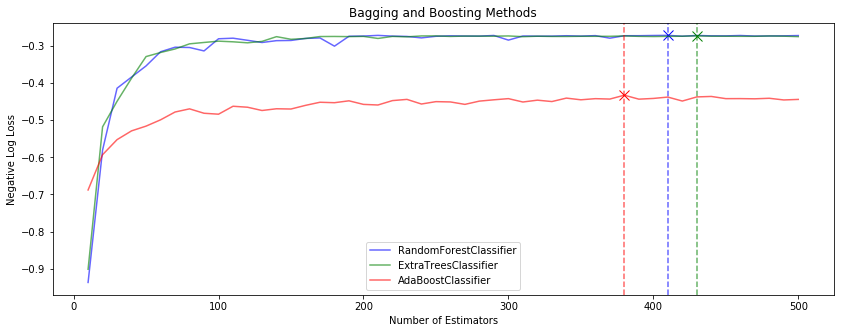

In [61]:
# Review results of hyperparameter tuning
fig, ax = plt.subplots()
# Iterate over various models
for clf, color in zip(model_names, ['blue', 'green', 'red']):
    # Plot log loss
    ax.plot(np.arange(10, 501, 10), models[clf][clf + '_cv_results']['mean_test_score'], label=models[clf][clf + '_init'].__class__.__name__, color=color, alpha=0.6)
    # Plot a vertical line and a marker to indicate "best parameter"
    ax.axvline(models[clf][clf + '_best_params']['n_estimators'], linestyle='--', color=color, alpha=0.6)
    ax.plot(models[clf][clf + '_best_params']['n_estimators'], models[clf][clf + '_cv_results']['mean_test_score'].max(), marker='x', color=color, markersize=10)
# Set plot options
plt.title('Bagging and Boosting Methods')
plt.ylabel('Negative Log Loss')
plt.xlabel('Number of Estimators')
plt.legend()
plt.show()

For all of our algorithms, we see almost no gains past 300 estimators (and that is being conservative). Although GridSearchCV would choose much higher numbers for all but one of the algorithms, it is obvious that we are reaching a plateau of performance past which we will not see any noticeable gains but are likely to degrade the speed of our model or even overfit. For this reason, we will cap all algorithms at 300 estimators.

In [35]:
# Choose our parameters
rfc_param = {'n_estimators': 300}
etc_param = {'n_estimators': 300}
adt_param = {'n_estimators': 300}
chosen_params = [rfc_param, etc_param, adt_param]

In [36]:
model_names = ['rfc', 'etc', 'adt']
chose_params = [rfc_param, etc_param, adt_param]
model_inits = [rfc_init, etc_init, adt_init]
# Iterate through models
for clf, param, init in zip(model_names, chosen_params, model_inits):
    # Update each of the model parameters with chosen values
    models[clf][clf + '_model'] = models[clf][clf + '_init']
    for key, value in param.items():
        models[clf][clf + '_model'].__setattr__(key, value)
    # Initialize second bootstrap iterator
    bootstrap_2 = Bootstrap_Indices(bootstrap_n, bootstrap_m_2)
    # Gather an array of scores for significance testing using bootstrapping
    models[clf]['accuracy_scores'], models[clf]['f1_scores'], models[clf]['log_loss_scores'], models[clf]['precision_1'], models[clf]['recall_1'], models[clf]['fscore_1'], models[clf]['support_1'], models[clf]['precision_0'], models[clf]['recall_0'], models[clf]['fscore_0'], models[clf]['support_0'] = bootstrap_model(x_train, y_train, models[clf][clf + '_model'], bootstrap_2)

### Save Data for Future Use
Given the amount of time it takes to perform hyperparameter tuning and bootstrapping, we will save all of our results to avoid repeating the calculations

In [37]:
# Pickle the data for future use
with open('models.pickle', 'wb') as f:
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

### Open Data

In [15]:
with open('models.pickle', 'rb') as file:
     models = pickle.load(file)

# Algorithm Results

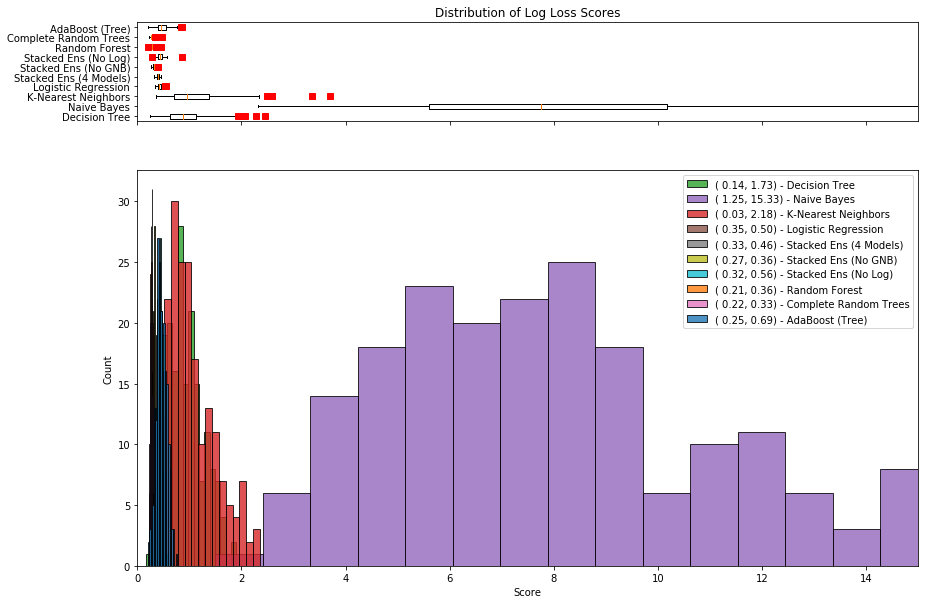

In [36]:
v_1 = ['tree', 'gnb', 'knn', 'log', 'se1', 'se2', 'se3', 'rfc', 'etc', 'adt']
scores = [models[clf]['log_loss_scores'] for clf in v_1]
names = [model_names[clf] for clf in v_1]
colors = [model_colors[clf] for clf in v_1]
plot_distributions(*scores, labels=names, scorer='Log Loss', colors=colors, num_bins=20, x_lim=[0.0, 15.0], alpha=0.8, plot_height=10, limit_outliers=True)

In [18]:
comparison(*scores, labels=names, scorer='Log Loss')

Comparison of Log Loss Scores
  Decision Tree           Mean: 0.93  Std: 0.41  95%Conf: (0.14, 1.73)
  Naive Bayes             Mean: 8.29  Std: 3.59  95%Conf: (1.25, 15.33)
  K-Nearest Neighbors     Mean: 1.11  Std: 0.55  95%Conf: (0.03, 2.18)
  Logistic Regression     Mean: 0.42  Std: 0.04  95%Conf: (0.35, 0.50)
  Stacked Ens (4 Models)  Mean: 0.39  Std: 0.03  95%Conf: (0.33, 0.46)
  Stacked Ens (No GNB)    Mean: 0.31  Std: 0.02  95%Conf: (0.27, 0.36)
  Stacked Ens (No Log)    Mean: 0.44  Std: 0.06  95%Conf: (0.32, 0.56)
  Random Forest           Mean: 0.28  Std: 0.04  95%Conf: (0.21, 0.36)
  Complete Random Trees   Mean: 0.28  Std: 0.03  95%Conf: (0.22, 0.33)
  AdaBoost (Tree)         Mean: 0.47  Std: 0.11  95%Conf: (0.25, 0.69)


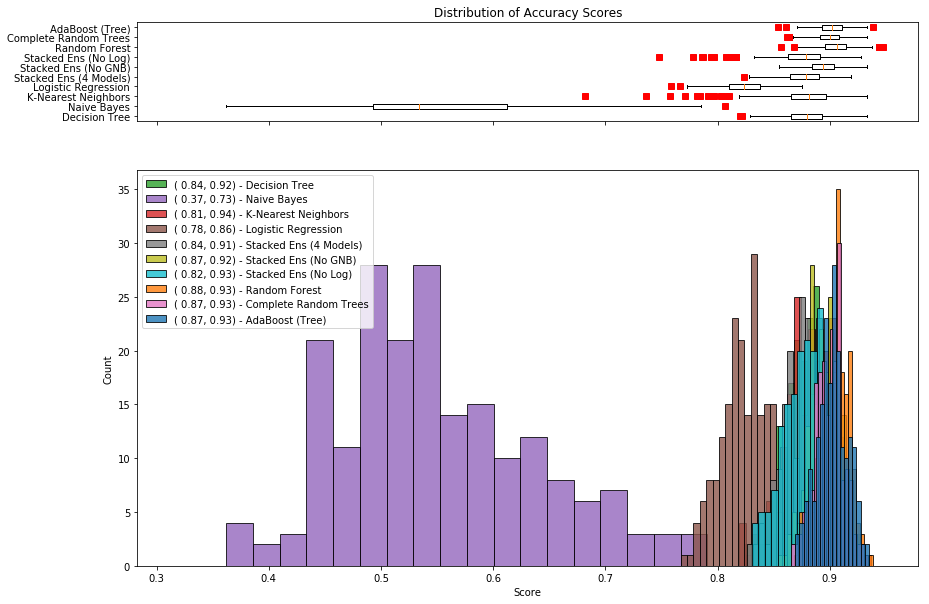

In [37]:
v_1 = ['tree', 'gnb', 'knn', 'log', 'se1', 'se2', 'se3', 'rfc', 'etc', 'adt']
scores = [models[clf]['accuracy_scores'] for clf in v_1]
names = [model_names[clf] for clf in v_1]
colors = [model_colors[clf] for clf in v_1]
plot_distributions(*scores, labels=names, scorer='Accuracy', colors=colors, num_bins=20, alpha=0.8, plot_height=10, limit_outliers=True)

In [20]:
comparison(*scores, labels=names, scorer='Accuracy')

Comparison of Accuracy Scores
  Decision Tree           Mean: 0.88  Std: 0.02  95%Conf: (0.84, 0.92)
  Naive Bayes             Mean: 0.55  Std: 0.09  95%Conf: (0.37, 0.73)
  K-Nearest Neighbors     Mean: 0.87  Std: 0.03  95%Conf: (0.81, 0.94)
  Logistic Regression     Mean: 0.82  Std: 0.02  95%Conf: (0.78, 0.86)
  Stacked Ens (4 Models)  Mean: 0.88  Std: 0.02  95%Conf: (0.84, 0.91)
  Stacked Ens (No GNB)    Mean: 0.89  Std: 0.01  95%Conf: (0.87, 0.92)
  Stacked Ens (No Log)    Mean: 0.87  Std: 0.03  95%Conf: (0.82, 0.93)
  Random Forest           Mean: 0.90  Std: 0.01  95%Conf: (0.88, 0.93)
  Complete Random Trees   Mean: 0.90  Std: 0.01  95%Conf: (0.87, 0.93)
  AdaBoost (Tree)         Mean: 0.90  Std: 0.01  95%Conf: (0.87, 0.93)


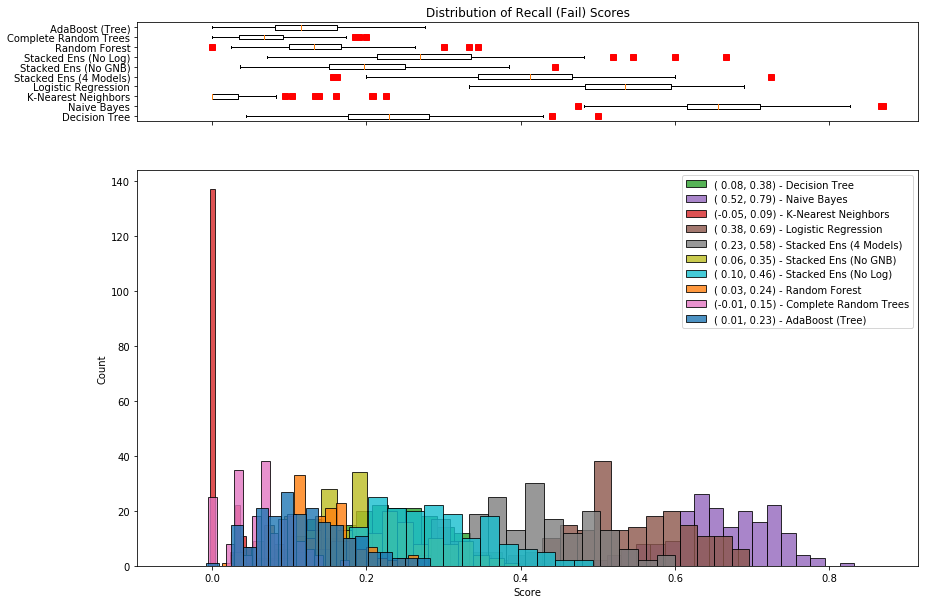

In [38]:
v_1 = ['tree', 'gnb', 'knn', 'log', 'se1', 'se2', 'se3', 'rfc', 'etc', 'adt']
scores = [models[clf]['recall_0'] for clf in v_1]
names = [model_names[clf] for clf in v_1]
colors = [model_colors[clf] for clf in v_1]
plot_distributions(*scores, labels=names, scorer='Recall (Fail)', colors=colors, num_bins=20, alpha=0.8, plot_height=10, limit_outliers=True)

In [39]:
comparison(*scores, labels=names, scorer='Recall (Fail)')

Comparison of Recall (Fail) Scores
  Decision Tree           Mean: 0.23  Std: 0.08  95%Conf: (0.08, 0.38)
  Naive Bayes             Mean: 0.66  Std: 0.07  95%Conf: (0.52, 0.79)
  K-Nearest Neighbors     Mean: 0.02  Std: 0.04  95%Conf: (-0.05, 0.09)
  Logistic Regression     Mean: 0.54  Std: 0.08  95%Conf: (0.38, 0.69)
  Stacked Ens (4 Models)  Mean: 0.41  Std: 0.09  95%Conf: (0.23, 0.58)
  Stacked Ens (No GNB)    Mean: 0.21  Std: 0.07  95%Conf: (0.06, 0.35)
  Stacked Ens (No Log)    Mean: 0.28  Std: 0.09  95%Conf: (0.10, 0.46)
  Random Forest           Mean: 0.14  Std: 0.05  95%Conf: (0.03, 0.24)
  Complete Random Trees   Mean: 0.07  Std: 0.04  95%Conf: (-0.01, 0.15)
  AdaBoost (Tree)         Mean: 0.12  Std: 0.06  95%Conf: (0.01, 0.23)


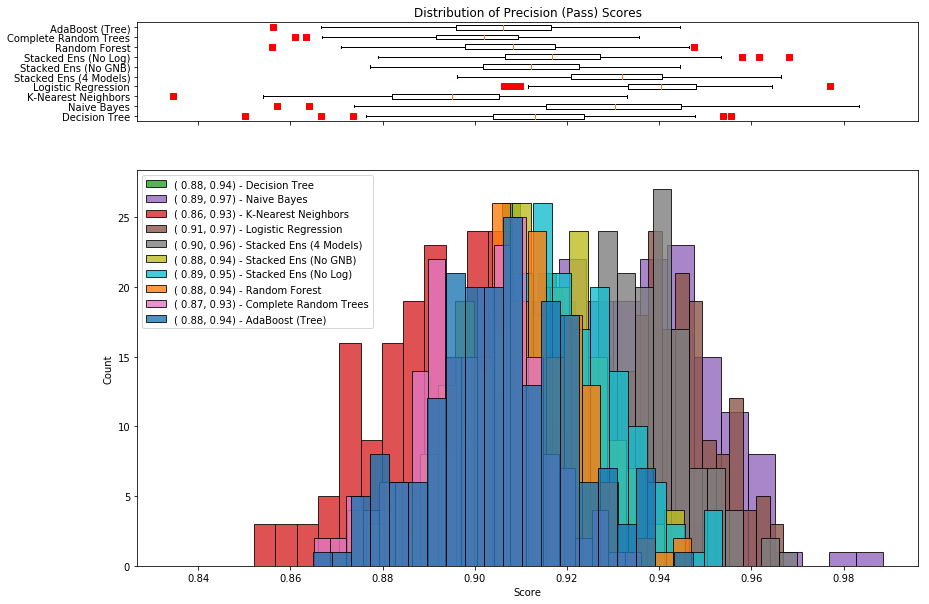

In [40]:
v_1 = ['tree', 'gnb', 'knn', 'log', 'se1', 'se2', 'se3', 'rfc', 'etc', 'adt']
scores = [models[clf]['precision_1'] for clf in v_1]
names = [model_names[clf] for clf in v_1]
colors = [model_colors[clf] for clf in v_1]
plot_distributions(*scores, labels=names, scorer='Precision (Pass)', colors=colors, num_bins=20, alpha=0.8, plot_height=10, limit_outliers=True)

In [41]:
comparison(*scores, labels=names, scorer='Precision (Pass)')

Comparison of Precision (Pass) Scores
  Decision Tree           Mean: 0.91  Std: 0.02  95%Conf: (0.88, 0.94)
  Naive Bayes             Mean: 0.93  Std: 0.02  95%Conf: (0.89, 0.97)
  K-Nearest Neighbors     Mean: 0.89  Std: 0.02  95%Conf: (0.86, 0.93)
  Logistic Regression     Mean: 0.94  Std: 0.01  95%Conf: (0.91, 0.97)
  Stacked Ens (4 Models)  Mean: 0.93  Std: 0.01  95%Conf: (0.90, 0.96)
  Stacked Ens (No GNB)    Mean: 0.91  Std: 0.01  95%Conf: (0.88, 0.94)
  Stacked Ens (No Log)    Mean: 0.92  Std: 0.02  95%Conf: (0.89, 0.95)
  Random Forest           Mean: 0.91  Std: 0.02  95%Conf: (0.88, 0.94)
  Complete Random Trees   Mean: 0.90  Std: 0.01  95%Conf: (0.87, 0.93)
  AdaBoost (Tree)         Mean: 0.91  Std: 0.02  95%Conf: (0.88, 0.94)


# Plot Decision Boundaries

In [26]:
# Determine variables to plot against
x_lab = 'Psychosocial Integrity'
y_lab = 'Ante/Intra/Postpartum and Newborn Care'

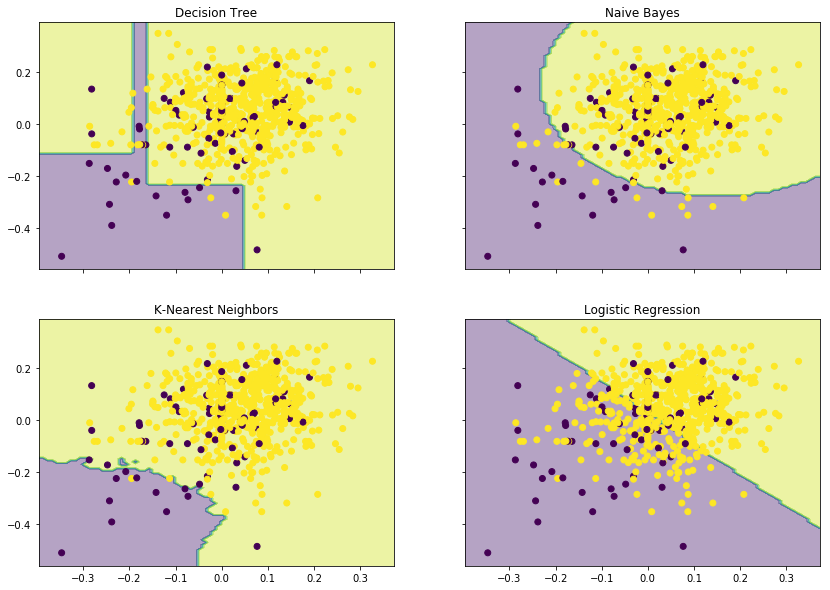

In [43]:
# Decision boundaries for standard classifiers
v_1 = ['tree', 'gnb', 'knn', 'log']
clfs = [models[clf][clf + '_model'] for clf in v_1]
names = [model_names[clf] for clf in v_1]
plot_decision_boundaries(x_train, y_train, x_lab, y_lab, *clfs, labels=names)

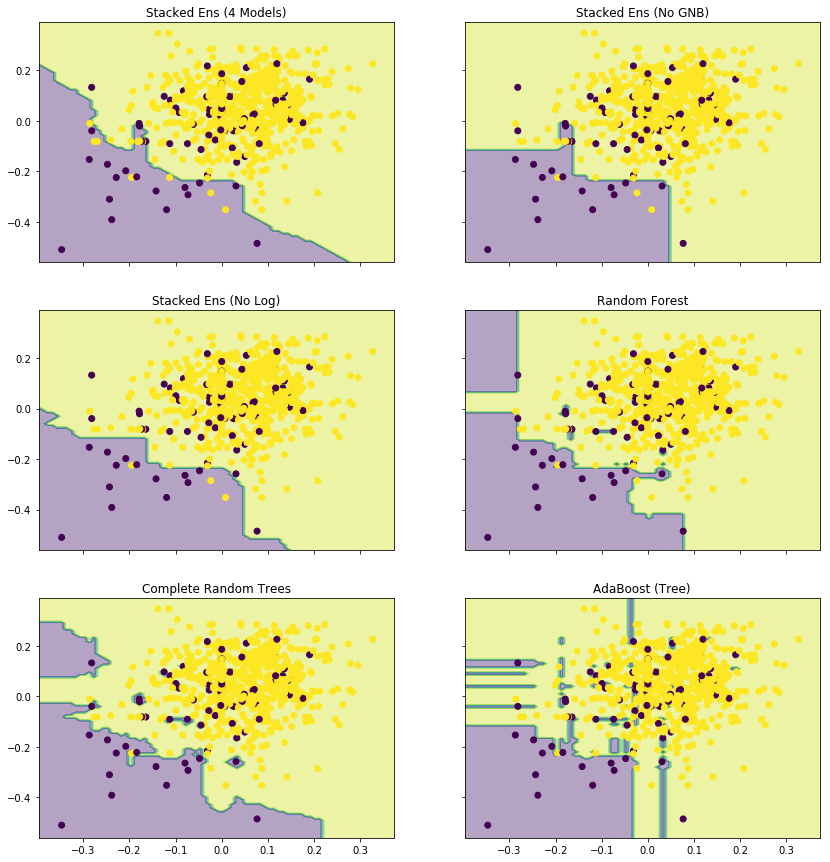

In [44]:
# Decision boundaries for ensemble methods
v_1 = ['se1', 'se2', 'se3', 'rfc', 'etc', 'adt']
clfs = [models[clf][clf + '_model'] for clf in v_1]
names = [model_names[clf] for clf in v_1]
plot_decision_boundaries(x_train, y_train, x_lab, y_lab, *clfs, labels=names)

# Export Decision Tree Graph

In [45]:
# Review the parameters chosen in hyperparameter tuning
models['tree']['tree_best_params']

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 7}

In [46]:
# Train the algorithm
models['tree']['tree_model'].fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [47]:
# Export tree graph (displays poorly within Jupyter Notebook)
dot_data = tree.export_graphviz(models['tree']['tree_model'], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=['Fail', 'Pass'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('DecisionTree')

'DecisionTree.pdf'

# Final Comparisons

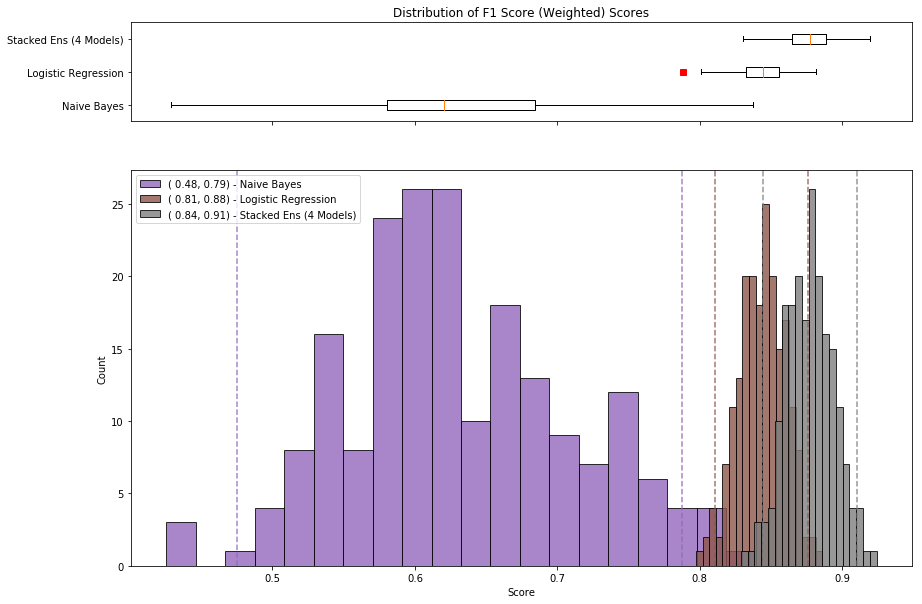

In [111]:
v_1 = ['gnb', 'log', 'se1']
scores = [models[clf]['f1_scores'] for clf in v_1]
names = [model_names[clf] for clf in v_1]
colors = [model_colors[clf] for clf in v_1]
plot_distributions(*scores, labels=names, scorer='F1 Score (Weighted)', colors=colors, num_bins=20, conf_lines=True, alpha=0.8, plot_height=10, limit_outliers=True)

In [72]:
comparison(*scores, labels=names, scorer='F1 Score (Weighted)')

Comparison of F1 Score (Weighted) Scores
  Naive Bayes             Mean: 0.63  Std: 0.08  95%Conf: (0.48, 0.79)
  Logistic Regression     Mean: 0.84  Std: 0.02  95%Conf: (0.81, 0.88)
  Stacked Ens (4 Models)  Mean: 0.88  Std: 0.02  95%Conf: (0.84, 0.91)


In [104]:
scores = [models[clf]['precision_0'] for clf in v_1]
comparison(*scores, labels=names, scorer='Precision (Fail)')

Comparison of Precision (Fail) Scores
  Naive Bayes             Mean: 0.15  Std: 0.04  95%Conf: (0.07, 0.23)
  Logistic Regression     Mean: 0.31  Std: 0.05  95%Conf: (0.21, 0.41)
  Stacked Ens (4 Models)  Mean: 0.42  Std: 0.09  95%Conf: (0.24, 0.60)


In [105]:
scores = [models[clf]['recall_0'] for clf in v_1]
comparison(*scores, labels=names, scorer='Recall (Fail)')

Comparison of Recall (Fail) Scores
  Naive Bayes             Mean: 0.66  Std: 0.07  95%Conf: (0.52, 0.79)
  Logistic Regression     Mean: 0.54  Std: 0.08  95%Conf: (0.38, 0.69)
  Stacked Ens (4 Models)  Mean: 0.41  Std: 0.09  95%Conf: (0.23, 0.58)


In [106]:
scores = [models[clf]['precision_1'] for clf in v_1]
comparison(*scores, labels=names, scorer='Precision (Pass)')

Comparison of Precision (Pass) Scores
  Naive Bayes             Mean: 0.93  Std: 0.02  95%Conf: (0.89, 0.97)
  Logistic Regression     Mean: 0.94  Std: 0.01  95%Conf: (0.91, 0.97)
  Stacked Ens (4 Models)  Mean: 0.93  Std: 0.01  95%Conf: (0.90, 0.96)


In [107]:
scores = [models[clf]['recall_1'] for clf in v_1]
comparison(*scores, labels=names, scorer='Recall (Pass)')

Comparison of Recall (Pass) Scores
  Naive Bayes             Mean: 0.54  Std: 0.10  95%Conf: (0.34, 0.74)
  Logistic Regression     Mean: 0.86  Std: 0.03  95%Conf: (0.81, 0.91)
  Stacked Ens (4 Models)  Mean: 0.93  Std: 0.02  95%Conf: (0.89, 0.98)


# Perform T-Tests

In [114]:
compare_scores(*scores[::-1], labels=names[::-1], alternate='more', alpha=0.01)

Ho: Stacked Ens (4 Models) <= Logistic Regression
Ha: Stacked Ens (4 Models) > Logistic Regression
Reject Ho when p/2 < 0.005 and t > 0
	T-statistic: 20.19, P-value: 6.594095102399295e-63
	Reject the null hypothesis.

Ho: Stacked Ens (4 Models) <= Naive Bayes
Ha: Stacked Ens (4 Models) > Naive Bayes
Reject Ho when p/2 < 0.005 and t > 0
	T-statistic: 42.51, P-value: 4.770702386511679e-150
	Reject the null hypothesis.



# Evaluate Time to Fit and Time to Query

In [139]:
v_1 = ['tree', 'gnb', 'knn', 'log', 'se1', 'se2', 'se3', 'rfc', 'etc', 'adt']
max_l = len(max(model_names.values(), key=len))
print('Comparison of Fit Time and Query Time:')
print('{0:<{1}} {2:>10}\t{3:>10}'.format('Algorithm', max_l, 'Fit Time', 'Query Time'))
for clf in v_1:
    if clf + '_cv_results' in models[clf].keys():
        idx = models[clf][clf + '_cv_results']['rank_test_score'].argmin()
        fit_time = models[clf][clf + '_cv_results']['mean_fit_time'][idx]
        score_time = models[clf][clf + '_cv_results']['mean_score_time'][idx]
        print('{0:<{1}} {2:>10.4f}\t{3:>10.4f}'.format(model_names[clf], max_l, fit_time, score_time))
    else:
        fit_time = 'N/A'
        score_time = 'N/A'
        print('{0:<{1}} {2:>10}\t{3:>10}'.format(model_names[clf], max_l, fit_time, score_time))

Comparison of Fit Time and Query Time:
Algorithm                Fit Time	Query Time
Decision Tree              0.0204	    0.0017
Naive Bayes                0.0061	    0.0031
K-Nearest Neighbors        0.0063	    1.0106
Logistic Regression        0.0194	    0.0023
Stacked Ens (4 Models)        N/A	       N/A
Stacked Ens (No GNB)          N/A	       N/A
Stacked Ens (No Log)          N/A	       N/A
Random Forest              1.9547	    0.1552
Complete Random Trees      1.2461	    0.2085
AdaBoost (Tree)            7.6927	    0.0812


# Train Algorithm and Report Scores against Holdout Set

In [147]:
clf = models['se1']['se1_model']
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
y_pred_prob = clf.predict_proba(x_test)
print('Log Loss: {0:.2f}'.format(log_loss(y_test, y_pred_prob)))
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))

Log Loss: 0.34
Accuracy: 0.89
             precision    recall  f1-score   support

          0       0.48      0.65      0.55        20
          1       0.96      0.92      0.94       172

avg / total       0.91      0.89      0.90       192

Confusion Matrix:
[[ 13   7]
 [ 14 158]]


# Train Production Model on All Data

In [145]:
models['se1']['production_model'] = models['se1']['se1_model']
models['se1']['production_model'].fit(df, target['Result']);